## Dataset importation
At first, we import the dataset in csv format and perform an essential exploration of its features.

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load data
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
print(data.columns)
data.head()

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Pre-processing of the data

Since some labels are missing, we will only consider the players with both ratings, for the training dataset. We will also see that there are no players with a single rating missing.

In [3]:
missing_rater_data=data[data.rater2.isnull() & data.rater1.isnull()]
rater_data=data[data.rater2.notnull() & data.rater1.notnull()]

In [4]:
data_one_rater2 = data[data.rater2.isnull() & ~data.rater1.isnull()]
data_one_rater1 = data[data.rater1.isnull() & ~data.rater2.isnull()]
print('There are '+str(len(data_one_rater2)+len(data_one_rater1))+
      ' player(s) with a single rating missing.')
print('Out of '+str(data.shape[0])+' data entries, we will only consider '+
      str(rater_data.shape[0])+' of them, i.e. '+str(rater_data.shape[0]*
                                                        100/data.shape[0])
      +'% of the entries, because of '+str(missing_rater_data.shape[0])+
      ' entries for which the skin color has not been rated.')

There are 0 player(s) with a single rating missing.
Out of 146028 data entries, we will only consider 124621 of them, i.e. 85.34048264716355% of the entries, because of 21407 entries for which the skin color has not been rated.


## Data analysis
### Preprocessing
In this preprocessing step, we will:
- Delete the column photoID
- Delete all the rows corresponding to a referee with less than 22 entry (indeed, this is impossible to have a referee with less than 22 entries, that corresponds to the number of players in two teams, that is the minimum number of players necessary for one game). This is done in function preprocess_1
- Remove the less significant referee entry, that is the entries with an nIAT and an nExp too low). This is done in function preprocess_2

In [5]:
def preprocess_1(database,remove_bad_referee=True,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    del train['photoID']
    
    train_group=train.groupby(train.refNum)
    
    if remove_bad_referee:
        for i,group in train_group:
            if group.shape[0]<22:
                train=train.drop(train_group.get_group(i).index)
            if i%500==0:
                print(i)
    
   
    return train

In [6]:
train_after_prep_1=preprocess_1(rater_data,remove_bad_referee=True)

500
1000
1500
2000
2500
3000


In [7]:
def preprocess_2(database,nIAT_threshold=50,nExp_threshold=50):
    train=database.copy()
    train_group=database.groupby(train.refNum)

    for i,group in train_group:
        if group.nIAT.iloc[0]<nIAT_threshold or group.nExp.iloc[0]<nExp_threshold:
            train=train.drop(train_group.get_group(i).index)
        if i%200==0:
            print(i)
    return train

In [8]:
train_after_prep_2=preprocess_2(train_after_prep_1)

1600
2400
3000


In [9]:
print('After the 2 preprocessing steps, '+str(train_after_prep_2.shape[0])
      +' of the entries remain, that is '+str(train_after_prep_2.shape[0]*100
                                              /rater_data.shape[0])+'% of them.')

After the 2 preprocessing steps, 111533 of the entries remain, that is 89.49775719982989% of them.


We normalize the number of victories, ties, defeats, goals, yellowCards, redCards and yellowReds by the number of games done with each referee, for the data to be comparable. To do so, we just quickly check that no dyad (player,referee) has a total number of games played together of 0. And then we delete the 'games' column that is not important anymore. 

In [10]:
entries = ['victories','ties','defeats','goals','yellowCards','yellowReds','redCards']
data_clean = pd.DataFrame()
print(train_after_prep_2[train_after_prep_2['games']==0].shape[0], 
      'dyad (player,referee) have a null total number of games played together.')

0 dyad (player,referee) have a null total number of games played together.


In [11]:
for ent in entries:
    train_after_prep_2[ent] = train_after_prep_2[ent]/train_after_prep_2.games
entries.append('games')
train_after_prep_2[entries].head(10)

,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,games
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,1.0,0.0,0.0,0.0,0.5,0.0,0.0,2
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [12]:
del train_after_prep_2['games']
del train_after_prep_2['player']

We have also deleted the 'player' column since it is in bijection with the playerShort name. We will now remove the nan values by filling NaN with median of the columns or with 'nan' if it is a categorical variable. 

In [13]:
train = train_after_prep_2
train.position=train.position.fillna('nan')

In [14]:
train.leagueCountry=train.leagueCountry.fillna('nan')

In [15]:
train=train.fillna(train.median())

In this way, we should not have any nan value anymore now, so that if we are carefull enough, we should have to deal with NaNs anymore in the following.

In [16]:
print(len(train[train.meanExp.isnull()]))
print(len(train[train.meanIAT.isnull()]))

0
0


In [17]:
summ = 0
for col in train.columns:
    summ = summ+train[train[col].isnull()].shape[0]
print('There are',summ, 'NaN value(s) left in our dataframe.')

There are 0 NaN value(s) left in our dataframe.


We keep only the year of birth (not the date), and we transorm it into an int.

In [18]:
train.birthday=train.birthday.apply(lambda x: int(x.split('.')[2]))

Now, we notice that the IAT and the Exp are here to identify how much can a referee be racist. In order to only keep information about the player itself, or the relation between the player and the referee, we choose to ponderate the yellowCards, redCards and yellowReds by the IAT and the Exp. This is indeed in the way to prepare the group_by player.

In [19]:
train['IAT_yellow']=train.yellowCards*train.meanIAT
train['IAT_red']=train.redCards*train.meanIAT
train['Exp_yellow']=train.yellowCards*train.meanExp
train['Exp_red']=train.redCards*train.meanExp
train['ITA_yellowred']=train.yellowReds*train.meanIAT
train['Exp_yellowred']=train.yellowReds*train.meanExp

Now, we delete the unwanted and unnecessary columns, i.e. the ones that give information only on the referee.

In [20]:
train = train.drop(['meanIAT','nIAT','seIAT','meanExp','nExp','seExp','refCountry',
                    'refNum','Alpha_3'], axis=1)

In [21]:
train.head(5)

,playerShort,club,leagueCountry,birthday,height,weight,position,victories,ties,defeats,...,yellowReds,redCards,rater1,rater2,IAT_yellow,IAT_red,Exp_yellow,Exp_red,ITA_yellowred,Exp_yellowred
5,aaron-hughes,Fulham FC,England,1979,182.0,71.0,Center Back,0.0,0.0,1.0,...,0.0,0.0,0.25,0.00,0.0,0.0,0.0,0.0,0.0,0.0
6,aleksandar-kolarov,Manchester City,England,1985,187.0,80.0,Left Fullback,1.0,0.0,0.0,...,0.0,0.0,0.00,0.25,0.0,0.0,0.0,0.0,0.0,0.0
7,alexander-tettey,Norwich City,England,1986,180.0,68.0,Defensive Midfielder,0.0,0.0,1.0,...,0.0,0.0,1.00,1.00,0.0,0.0,0.0,0.0,0.0,0.0
8,anders-lindegaard,Manchester United,England,1984,193.0,80.0,Goalkeeper,0.0,1.0,0.0,...,0.0,0.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0
9,andreas-beck,1899 Hoffenheim,Germany,1987,180.0,70.0,Right Fullback,1.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
short_data = train_after_prep_2[['playerShort','position']]
print('There are ', len(short_data[short_data.columns[short_data.iloc[0] 
                                                      == short_data.iloc[1]]].columns),
      'player(s) playing in two different positions.')
short_data = train_after_prep_2[['playerShort','club']]
print('There are ', len(short_data[short_data.columns[short_data.iloc[0] 
                                                      == short_data.iloc[1]]].columns),
      'player(s) playing in two different clubs.')

There are  0 player(s) playing in two different positions.
There are  0 player(s) playing in two different clubs.


This last information is some good news! It means that when we will group the data by players, we will not have to take too much care of the 'position' field nor the 'club' field since the function mapping the player to its position is well defined.

Some more operations in the data are done in the following:

- Add dummy variables for the categorical variables so that each cell has equal importance and there is no ordering issue between the categories.
- Keep one entry for each player (i.e. group_by player)
- Normalize all the entries to have numbers between 0 and 1, so that all fields have equal importance in the clustering
- Extract the mean of the rater1 and rater2 to get a new field skinColor and delete rater1 and rater2 columns

In [23]:
train.columns

Index(['playerShort', 'club', 'leagueCountry', 'birthday', 'height', 'weight',
       'position', 'victories', 'ties', 'defeats', 'goals', 'yellowCards',
       'yellowReds', 'redCards', 'rater1', 'rater2', 'IAT_yellow', 'IAT_red',
       'Exp_yellow', 'Exp_red', 'ITA_yellowred', 'Exp_yellowred'],
      dtype='object')

1- Replace string attributes by dummies variables

In [24]:
dumm=pd.get_dummies(train[['position','leagueCountry','club']])

In [25]:
train=pd.concat([train,dumm],axis=1)

In [26]:
del train['leagueCountry']
del train['position']
del train['position_nan']

In [27]:
train.columns

Index(['playerShort', 'club', 'birthday', 'height', 'weight', 'victories',
       'ties', 'defeats', 'goals', 'yellowCards',
       ...
       'club_Valencia CF', 'club_Valenciennes FC', 'club_VfB Stuttgart',
       'club_VfL Wolfsburg', 'club_Werder Bremen', 'club_West Bromwich Albion',
       'club_West Ham United', 'club_Wigan Athletic',
       'club_Wolverhampton Wanderers', 'club_Évian Thonon Gaillard'],
      dtype='object', length=132)

2- Aggregation: group by players.

In [28]:
train=train.groupby('playerShort').mean()

In [29]:
train.head()

,birthday,height,weight,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,club_Valencia CF,club_Valenciennes FC,club_VfB Stuttgart,club_VfL Wolfsburg,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,1979,182.0,71.0,0.430823,0.251705,0.317472,0.012870,0.036590,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-hunt,1986,183.0,73.0,0.470884,0.207979,0.321136,0.132798,0.093665,0.000000,0.000818,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
aaron-lennon,1987,165.0,63.0,0.524169,0.231699,0.244132,0.048311,0.018085,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron-ramsey,1990,178.0,76.0,0.554130,0.163463,0.282407,0.200943,0.128526,0.000000,0.010417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdelhamid-el-kaoutari,1990,180.0,73.0,0.313798,0.293912,0.392290,0.004082,0.065748,0.043129,0.011429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3- Normalize entries to equalize the importance of each attribute.

In [30]:
for col in train.columns:
    train[col] = (train[col]-train[col].min())/train[col].max()

4- Extract the mean of the skin colors given by the two raters.

In [31]:
train['skinColor']=(train['rater1']+train['rater2'])/2
del train['rater1']
del train['rater2']

In [32]:
train.head()

,birthday,height,weight,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,club_Valenciennes FC,club_VfB Stuttgart,club_VfL Wolfsburg,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard,skinColor
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.004008,0.103448,0.17,0.430823,0.251705,0.317472,0.017891,0.036590,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125
aaron-hunt,0.007515,0.108374,0.19,0.470884,0.207979,0.321136,0.184604,0.093665,0.000000,0.004910,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.125
aaron-lennon,0.008016,0.019704,0.09,0.524169,0.231699,0.244132,0.067158,0.018085,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250
aaron-ramsey,0.009519,0.083744,0.22,0.554130,0.163463,0.282407,0.279333,0.128526,0.000000,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
abdelhamid-el-kaoutari,0.009519,0.093596,0.19,0.313798,0.293912,0.392290,0.005674,0.065748,0.646939,0.068571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250


## Question 2: clustering
Choices to be done:
* Choice of the algorithm: KMeans (with this one, we can choose the final number of clusters we want) or DBSCAN (we have to impose a metric, but it is not suited for our goal since we cannot impose the number of clusters we want to find).
* Choice of 'init' paratmeter of KMeans
* Choice of the features to iterately remove, and in which order (in particular, with or without the rater's means)
* Sample size of the silhouette score

In [33]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from time import time

In [34]:
labels = 1*(train.skinColor>=0.5) # reference on the labels we should get (or 1-labels) 
# if the clustering were separating blacks from whites. 

In [35]:
def estimate_data(estimator, metric, name, data):
    t0 = time()
    estimator.fit(data)
    silh_score = metrics.silhouette_score(data, estimator.labels_, metric=metric)
    print('% 9s   %.2fs    %.3f'
         % (name, (time() - t0), silh_score))
    return silh_score

In [36]:
metric_silhouette = 'euclidean'
kmpp = KMeans(init='k-means++', n_clusters=2)
km_rand = KMeans(init='random', n_clusters=2)

s1 = estimate_data(kmpp,metric_silhouette,'k-means++ euclidean   ',train)
s2 = estimate_data(km_rand,metric_silhouette,'k-means rand euclidean',train)

k-means++ euclidean      1.22s    0.109
k-means rand euclidean   0.50s    0.109


We notice that both silhouettes are equal and not very high at all. This means that the two clusters have a high overlap, i.e. they are not so well distinct. Indeed, we have a high number of attributes, that is a high dimensionality of our problem, so that it is harder for the algorithm to find clear separate clusters. Moreover, lots of data do not cluster the players into only 2 clusters, but into more clusters (ex: by club, by country, etc.)

Let us see how this (low quality) clustering has separated blacks into white, by computing the mean of the "skinColor" values in each cluster. The more different is the mean (i.e. one cluster's value tending to 1 -the blacks-, the other one's tending to 0 -the whites-), the better the clustering has performed to separate blacks and whites. 

In [37]:
train0 = train[kmpp.labels_==0]
train1 = train[kmpp.labels_==1]
print('The mean color skin factor of cluster 1 is equal to', train0.skinColor.mean())
print('The mean color skin factor of cluster 2 is equal to', train1.skinColor.mean())
print('The total mean color skin is equal to', train.skinColor.mean(), 
      'if it is represented by steps of 0.25, or is equal to', labels.mean(), 
      'if it is represented as a binary value, with the threshold at 0.5.')

The mean color skin factor of cluster 1 is equal to 0.3257918552036199
The mean color skin factor of cluster 2 is equal to 0.20589770354906053
The total mean color skin is equal to 0.28953598484848486 if it is represented by steps of 0.25, or is equal to 0.24305555555555555 if it is represented as a binary value, with the threshold at 0.5.


We can see that the mean is quite the same in both cases, and is very close to the total mean skin color. This means that the two clusters have not been determined with respect to the skin color (or only slightly), but mostly with respect to some other factors. It is normal that both means tend to be closer to 0 than to 1 since the total mean skin color is of 0.28. 

We first collect the column labels and then class them by increasing order of importance with respect to our goal, that is see if we are able to cluster whites and blacks. All of that is done in order to be able to take the attributes out of the analysis one by one.

We expect that the less attributes and the more specific they are for our problem, the better will be the sihouette score, and the further apart will be the means of the two clusters, meaning that we are more able to differentiate blacks and whites. 

### Supposing we have the rater's evaluation of the skin color of the players

The importance ordering can obviously be controversed, and it influences a lot the clustering. Since our goal is to separate blacks from whites, we will plot the mean of each of the attributes for both blacks and whites, and see for which attributes it differs the most. The more it differs, the more "important" are the attributes to discriminate blacks and whites. 

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The following step can be performed only because we have the information about the skin color given by the raters. To be even more reliable, we would need more raters, but we will proceed anyway with only 2 raters.

In [132]:
train4plot = train.copy()
train4plot['binarySkinColor'] = labels
train4plot = train4plot.groupby('binarySkinColor').mean()
train4plot

,birthday,height,weight,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,club_Valenciennes FC,club_VfB Stuttgart,club_VfL Wolfsburg,club_Werder Bremen,club_West Bromwich Albion,club_West Ham United,club_Wigan Athletic,club_Wolverhampton Wanderers,club_Évian Thonon Gaillard,skinColor
binarySkinColor,,,,,,,,,,,,,,,,,,,,,
0,0.007363,0.104504,0.221735,0.442670,0.233914,0.323416,0.142041,0.134403,0.063204,0.025055,...,0.007506,0.017515,0.025855,0.021685,0.010842,0.010008,0.007506,0.000000,0.005838,0.145955
1,0.007786,0.101017,0.215844,0.420299,0.242388,0.337314,0.154467,0.120310,0.067070,0.031177,...,0.015584,0.018182,0.005195,0.010390,0.012987,0.015584,0.012987,0.002597,0.005195,0.736688


We plot the difference of eac

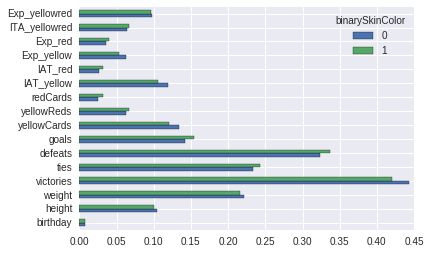

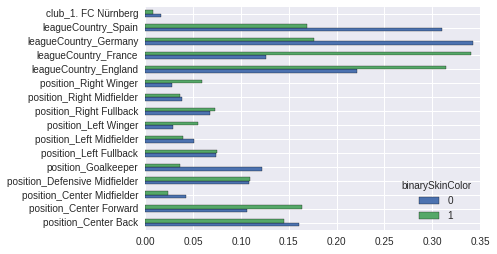

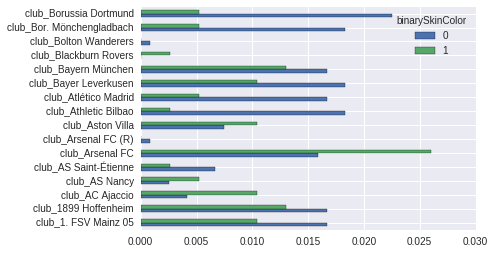

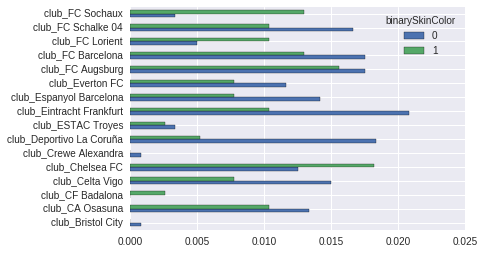

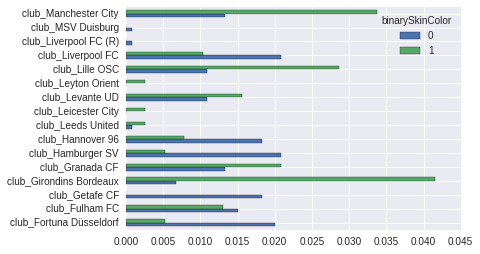

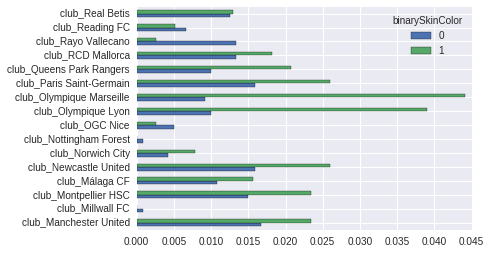

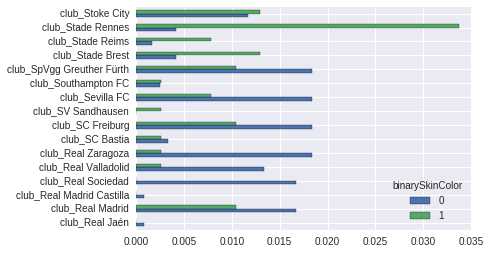

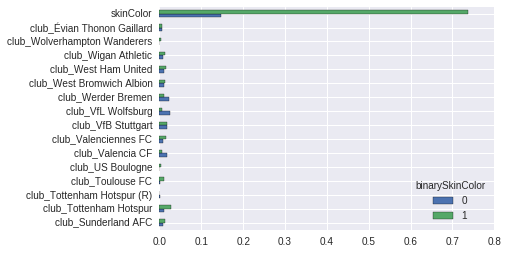

In [159]:
(train4plot.T)[:16].plot(kind='barh')
(train4plot.T)[17:33].plot(kind='barh')
(train4plot.T)[33:49].plot(kind='barh')
(train4plot.T)[49:65].plot(kind='barh')
(train4plot.T)[65:81].plot(kind='barh')
(train4plot.T)[81:97].plot(kind='barh')
(train4plot.T)[97:113].plot(kind='barh')
(train4plot.T)[113:].plot(kind='barh')

In [134]:
train_ordered = train4plot.diff(axis=0).abs()
train_ordered = train_ordered.iloc[1,:].sort_values()
train_ordered

club_Southampton FC              0.000095
birthday                         0.000423
club_Real Betis                  0.000477
club_Évian Thonon Gaillard       0.000643
position_Defensive Midfielder    0.000667
club_VfB Stuttgart               0.000667
Exp_yellowred                    0.000711
club_SC Bastia                   0.000739
club_ESTAC Troyes                0.000739
club_Crewe Alexandra             0.000834
club_Bristol City                0.000834
club_Nottingham Forest           0.000834
club_Real Jaén                   0.000834
club_MSV Duisburg                0.000834
club_Real Madrid Castilla        0.000834
club_Millwall FC                 0.000834
club_Bolton Wanderers            0.000834
club_Arsenal FC (R)              0.000834
club_Liverpool FC (R)            0.000834
club_Stoke City                  0.001311
club_Reading FC                  0.001477
club_Tottenham Hotspur (R)       0.001668
club_Leeds United                0.001763
position_Left Fullback           0

In [135]:
#train4plot = train[positions].copy()
#train4plot['binarySkinColor'] = labels
#train4plot = train4plot.groupby('binarySkinColor').mean()
#train4plot.T.plot(kind='barh')
#train_ordered = train4plot.diff(axis=0).abs()
#train_ordered = train_ordered.iloc[1,:].sort_values()
#train_ordered

The index of train_ordered is ordered in increasing order of importance of the attributes.

In [136]:
ordered_index = train_ordered.index
ordered_index

Index(['club_Southampton FC', 'birthday', 'club_Real Betis',
       'club_Évian Thonon Gaillard', 'position_Defensive Midfielder',
       'club_VfB Stuttgart', 'Exp_yellowred', 'club_SC Bastia',
       'club_ESTAC Troyes', 'club_Crewe Alexandra',
       ...
       'club_Girondins Bordeaux', 'club_Olympique Marseille',
       'position_Attacking Midfielder', 'position_Center Forward',
       'position_Goalkeeper', 'leagueCountry_England', 'leagueCountry_Spain',
       'leagueCountry_Germany', 'leagueCountry_France', 'skinColor'],
      dtype='object', length=129)

In [122]:
train[train_ordered.index].columns

Index(['birthday', 'Exp_yellowred', 'ITA_yellowred', 'height', 'Exp_red',
       'yellowReds', 'IAT_red', 'weight', 'redCards', 'ties', 'Exp_yellow',
       'goals', 'defeats', 'yellowCards', 'IAT_yellow', 'victories',
       'skinColor'],
      dtype='object')

In [137]:
scores = []
for i in range(0,len(col_idx)):
    scores.append(
        estimate_data(kmpp,metric_silhouette,'k-means++ euclidean  ',train[ordered_index[i:]]))

k-means++ euclidean     0.48s    0.109
k-means++ euclidean     0.46s    0.109
k-means++ euclidean     0.46s    0.109
k-means++ euclidean     0.45s    0.110
k-means++ euclidean     0.52s    0.111
k-means++ euclidean     0.50s    0.115
k-means++ euclidean     0.53s    0.114
k-means++ euclidean     0.47s    0.115
k-means++ euclidean     0.47s    0.115
k-means++ euclidean     0.46s    0.115
k-means++ euclidean     0.43s    0.115
k-means++ euclidean     0.43s    0.115
k-means++ euclidean     0.44s    0.115
k-means++ euclidean     0.44s    0.116
k-means++ euclidean     0.44s    0.116
k-means++ euclidean     0.48s    0.116
k-means++ euclidean     0.45s    0.116
k-means++ euclidean     0.44s    0.116
k-means++ euclidean     0.45s    0.116
k-means++ euclidean     0.45s    0.116
k-means++ euclidean     0.44s    0.117
k-means++ euclidean     0.43s    0.117
k-means++ euclidean     0.43s    0.117
k-means++ euclidean     0.42s    0.118
k-means++ euclidean     0.46s    0.121
k-means++ euclidean     0

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

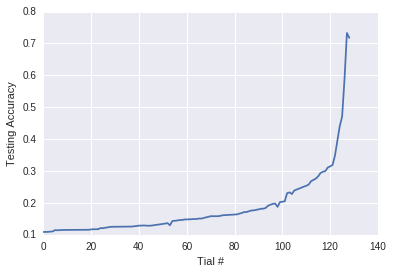

In [139]:
plt.plot(range(0,len(col_idx)), scores)
plt.xlabel('Tial #')
plt.ylabel('Testing Accuracy')